## I. Setup
First, we need to load the requisite libraries. `NumPy` is used only to demonstrate the use of custom metric functions. The heavy lifting is done by the `TPDataset` class, which is defined in `test_pulse_dataset.py`.

In [1]:
import numpy as np
from test_pulse_dataset import TPDataset

dbpath = '/Users/mueller/Projects/channel_status/db/icarus_channels_dev.db'

## II. Load the input `TPDatasets`
The input data is stored in the form of TH2Is contained in ROOT files. The `TPDataset` class is used as a container that handles the loading and analysis of data. This examples uses two datasets taken using the internal method of test pulse injection -- one with pulses injected on the odd channels and the other on the even channels. The class is also equipped with a `__repr__` method that allows for printing a summary of the dataset.

For some use cases it may be desirable to define a `TPDataset` as the difference (sum) of two other `TPDatasets`. This is implemented via overloaded `__sub__` (`__add__`) methods in the class. The difference (sum) is calculated channel-by-channel and tick-by-tick. The two datasets *must* have the same shape or else an exception will be raised.

It is also possible to define a `TPDataset` by "joining" two `TPDatasets` together. In this scenario, any channel which is not pulsed in the first dataset, but is pulsed in the second takes its pulse waveform to be the one from the second dataset. Naturally, the shapes must also match for this method.

In [2]:
# Load the datasets
data_odd = TPDataset('/Users/mueller/data/test_pulse/run10487.root', dbpath, which='average')
data_even = TPDataset('/Users/mueller/data/test_pulse/run10488.root', dbpath, which='average')

# Print summary
print(data_odd)

# Define "difference" of two datasets.
data_difference = data_odd - data_even

# Define "joint" dataset.
data_internal = data_odd.join(data_even)

Total Channels: 55296
Pulsed Channels: 27339


## III. Configure and Run the Analysis
Analysis of TPDatasets is streamlined via the `add_metric` and `run_analysis` member functions. The general procedure for performing an analysis is:
1. Configure all metrics: define each desired metric using the `add_metric` method. This function takes as arguments the callable (function) that operates on a waveform and produces the metric, the unique name that will be used to identify the metric, and any `kwargs` (key-word arguments) that will be passed to the callable. If a name which has already been used is passed, it will not be added.
2. Run the analysis: simply call the `run_analysis` function. This function runs all defined metric functions for all channels and stores the results in a `Pandas DataFrame`. Some other useful information is also stored in the `DataFrame`:
* `channel_id`: a unique identifier for the channel.
* `flange_name`: the name of the flange containing the channel.
* `slot_id`: the position of the readout board within the mini-crate containing the channel.
* `local_id`: the position of the channel within the readout board.
* `ploc`: the positive peak (maximum) location before cutting the pulse into positive and negative lobes. This *should* be ~75 by construction (configuration parameter in the LArSoft module).
* `mloc`: the negative peak (minimum) location before cutting the pulse into positive and negative lobes.
* `is_pulsed`: boolean that tags the channel as having a signal pulse (has some part over threshold=400 ADC).

In [3]:
def fwhm_metric(waveform, leading=True) -> float:
    """
    Calculates the full width at half maximum using the leading or trailing edge of
    the pulse.

    Parameters
    ----------
    waveform: np.array
        The pulse waveform
    leading: bool
        If True (False), calculates the full width at half maximum using the
        leading (trailing) edge
    
    Returns
    -------
    fwhm: float
        The full width at half maximum of the pulse.
    """
    half_max = np.max(waveform) / 2.0
    fwhm = np.abs(np.argmax(waveform) - np.argwhere(waveform > half_max)[0 if leading else -1,0])
    return fwhm

# Add a metric that calculates a basic peak height using NumPy's max function.
data_internal.add_metric(np.max, 'peak_height')

# Add metrics that calculate basic FWHM metrics using leading or trailing edges 
data_internal.add_metric(fwhm_metric, 'fwhm_leading', leading=True)
data_internal.add_metric(fwhm_metric, 'fwhm_trailing', leading=False)

# Run the analysis.
data_internal.run_analysis()

Metric with name "peak_height" has been added.
Metric with name "fwhm_leading" has been added (kwargs = {'leading': True}).
Metric with name "fwhm_trailing" has been added (kwargs = {'leading': False}).


,channel_id,flange_name,slot_id,local_id,ploc,mloc,is_pulsed,peak_height,fwhm_leading,fwhm_trailing
0,863,EE01T,0,0,75,698,True,1138.635379,3,4
1,862,EE01T,0,1,75,697,True,1147.595318,3,5
2,861,EE01T,0,2,75,698,True,1130.464342,3,5
3,860,EE01T,0,3,75,697,True,1143.135494,3,5
4,859,EE01T,0,4,75,698,True,1176.862672,3,5
...,...,...,...,...,...,...,...,...,...,...
55291,49220,WW20B,8,59,75,697,True,1254.017510,3,4
55292,49219,WW20B,8,60,75,697,True,1281.934386,3,4
55293,49218,WW20B,8,61,75,697,True,1265.239322,3,4
55294,49217,WW20B,8,62,75,697,True,1309.408230,3,4


## IV. Make Plots of the Results
The `TPDataset` class is equipped with a few functions that streamline the plotting of metrics:
* `plot_metric_board`: Plots a single metric as a 2D histogram across the common readout board grouping.
* `plot_metric_crate`: Plots a single metric as a 2D histogram across the common readout crate grouping.

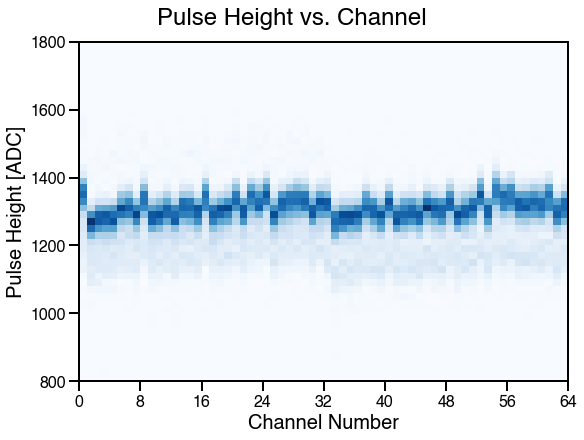

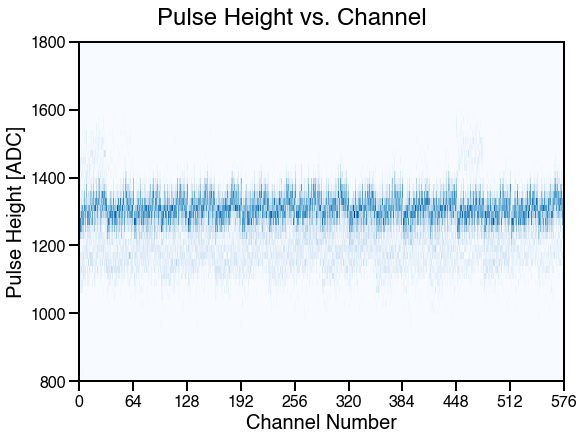

In [4]:
data_internal.plot_metric_board('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel')
data_internal.plot_metric_crate('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel')

## V. Compare Internal and Flange Test Pulse Injection
We can use these plotting utilities to compare the characteristics of different test pulse injection methods. We already have the TPDataset corresponding to the internal test pulse injection data, so we only need to load the data from the flange-based test pulse injection (in-phase). As before, the data is contained in two separate datasets (corresponding to different sets of connectors/planes) and must be joined first. 

In [5]:
# Load both "halves" of the dataset.
data_conn12 = TPDataset('/Users/mueller/data/test_pulse/waveforms_conn12_inphase.root', dbpath)
data_conn34 = TPDataset('/Users/mueller/data/test_pulse/waveforms_conn34_inphase.root', dbpath)
data_inphase = data_conn12.join(data_conn34)

# Configure and run the analysis.
data_inphase.add_metric(np.max, 'peak_height')
data_inphase.run_analysis()

Metric with name "peak_height" has been added.


,channel_id,flange_name,slot_id,local_id,ploc,mloc,is_pulsed,peak_height
0,863,EE01T,0,0,75,75,False,0.0
1,862,EE01T,0,1,75,75,False,0.0
2,861,EE01T,0,2,75,75,False,0.0
3,860,EE01T,0,3,75,75,False,0.0
4,859,EE01T,0,4,75,75,False,0.0
...,...,...,...,...,...,...,...,...
55291,49220,WW20B,8,59,75,75,False,0.0
55292,49219,WW20B,8,60,75,75,False,0.0
55293,49218,WW20B,8,61,75,75,False,0.0
55294,49217,WW20B,8,62,75,75,False,0.0


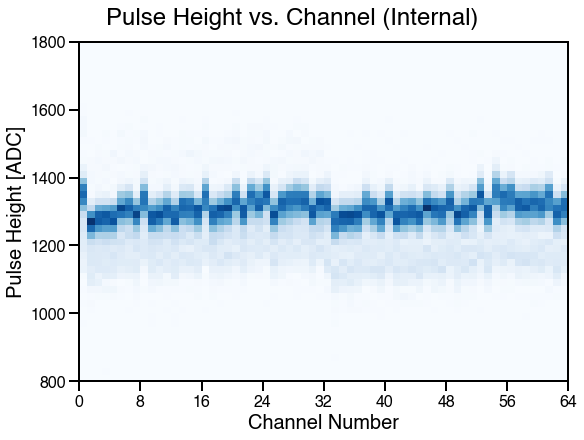

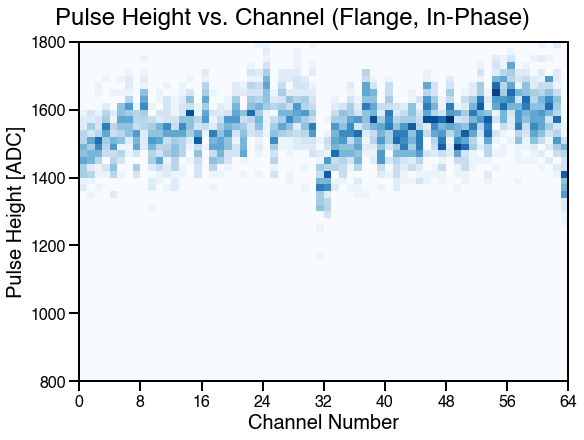

In [6]:
# Plot the peak height across the common readout board grouping.
data_internal.plot_metric_board('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel (Internal)')
data_inphase.plot_metric_board('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel (Flange, In-Phase)')

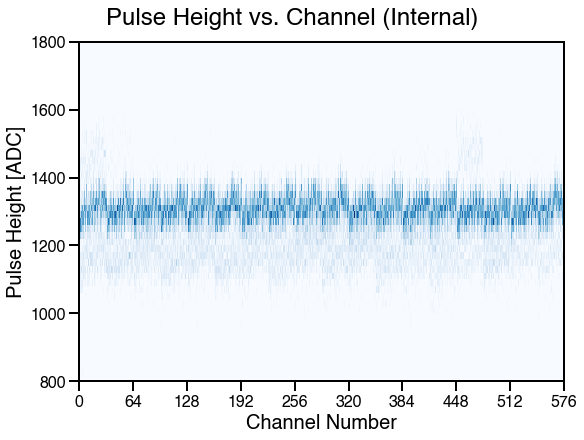

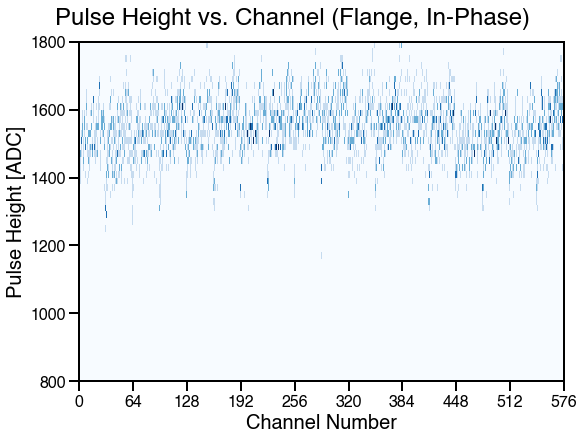

In [7]:
# Plot the peak height across the common readout mini-crate grouping.
data_internal.plot_metric_crate('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel (Internal)')
data_inphase.plot_metric_crate('peak_height', (800, 1800), 'Pulse Height [ADC]', 'Pulse Height vs. Channel (Flange, In-Phase)')

## VI. Connectivity Test Results
The data taken for the connectivity test includes ten full waveforms per channel for most, but not all, mini-crates. The test pulse was injected in identically the same way as the current "flange-based" injection data, but the waveforms were digitized by an oscilloscope after coming out of the DBBs and a custom-made pre-amplifier. These waveforms are each 10,000 samples long and so present a different case to the usual pulse waveforms. As in the previous cases, each waveform was added coherently per channel and placed in an array of shape (10001, 55296). This array was stored in a `npz`, which this code knows how to read.

We also noticed a repeating pattern with a modulation of four channels. We believe that the pre-amplifier box which multiplexes the channels from the cable to four oscilloscope channels may have four separate pre-amplifiers. We also know that there were two separate pre-amplifier boxes, so this potentially divides the channels into eight separate populations. We can easily divide the channels into four populations using modulo arithmetic, then apply an equalization factor to the waveforms based on the median peak heights of the populations. This results in a second set of modified waveforms. 

In [8]:
data_connectivity = TPDataset('/Users/mueller/data/test_pulse/connectivity/connectivity_results.npz', dbpath)
data_connectivity_equalized = TPDataset('/Users/mueller/data/test_pulse/connectivity/connectivity_results_equalized.npz', dbpath)

In [9]:
data_connectivity.add_metric(np.max, 'peak_height')
data_connectivity.add_metric(np.min, 'min_height')
data_connectivity.add_metric(np.median, 'median')
connectivity_metrics = data_connectivity.run_analysis()

data_connectivity_equalized.add_metric(np.max, 'peak_height')
data_connectivity_equalized.add_metric(np.min, 'min_height')
data_connectivity_equalized.add_metric(np.median, 'median')
connectivity_metrics_equalized = data_connectivity_equalized.run_analysis()

Metric with name "peak_height" has been added.
Metric with name "min_height" has been added.
Metric with name "median" has been added.
Metric with name "peak_height" has been added.
Metric with name "min_height" has been added.
Metric with name "median" has been added.


We noticed quite a large population of outlier channels which have been attributed to channels with short wires. This can be cleaned up by the application of a boolean mask.

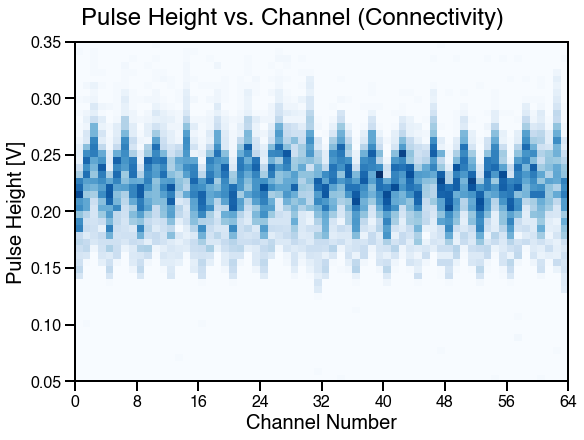

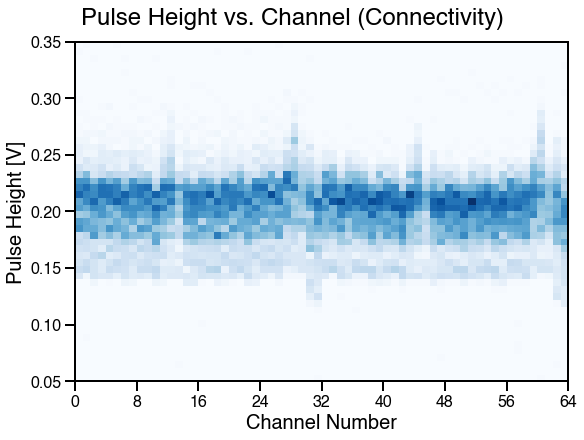

In [10]:
mask = np.array([x[2:4] != 'ne' and int(x[2:4]) >= 4 and int(x[2:4]) <= 17 for x in connectivity_metrics['flange_name']])
data_connectivity.plot_metric_board('peak_height', (0.05, 0.35), 'Pulse Height [V]', 'Pulse Height vs. Channel (Connectivity)', mask=mask)
data_connectivity_equalized.plot_metric_board('peak_height', (0.05, 0.35), 'Pulse Height [V]', 'Pulse Height vs. Channel (Connectivity)', mask=mask)